In [1]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests

## Q 3 Saliency maps and adversarial attacks

### Q3.1 Load a pretrained model from torch vision and compute saliency map for predicted class


In [2]:
import torchvision.models as models

In [3]:
! wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2020-10-16 15:45:16--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.240.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.240.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.01s   

2020-10-16 15:45:16 (2.42 MB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



In [4]:
import json
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
imagenet_transform = transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                     ])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
make_viewable = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])

pil = transforms.ToPILImage()

In [6]:
url = "https://cdn.wimmel-napkins.com/F/1/AM/g13312895.jpg"
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")

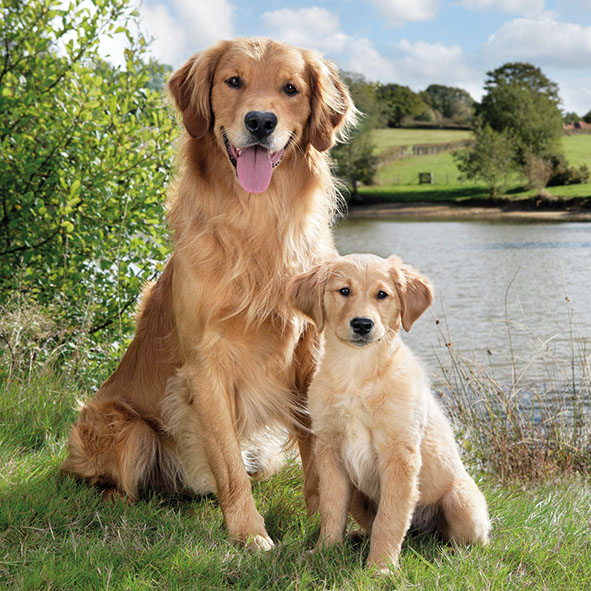

In [7]:
im

### Pass this image through the forward pass of your model to see what the model predicts. For this class, compute the saliency map using the un-normalized score for that class. Details in Sec 3.1 of [1].

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.

IMP: Remember to put the model in eval mode and use un-normalized class scores


In [ ]:
def compute_saliency_maps(X, model):
  """
  Compute a class saliency map using the model for image X.
  
  Input:
  - X: Input image, shape is (1, 3, H, W)
  - model: A pretrained CNN that will be used to compute the saliency map.
  
  Returns:
  - saliency: An array of shape (1, H, W) giving the saliency map for the input
    image.
  - predicted_class_id: ID of the class with highest score with respect to 
    which you calculated the saliency map
  """  

  # TODO
  model.eval()
  X.requires_grad_()

  scores = model(X)
  max_score, predicted_class_id = torch.max(scores, 1)
  max_score.backward()

  grad = X.grad.data
  saliency,_ = torch.max(grad.abs(), dim=1)
  X.requires_grad = False

  return saliency, predicted_class_id

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



tensor([207]) golden_retriever


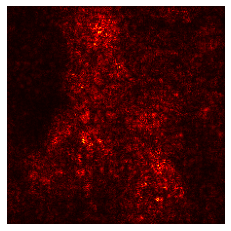

In [ ]:
model = models.resnet18(pretrained=True)
X = imagenet_transform(im).unsqueeze(0).to(device)
saliency, predicted_class_id = compute_saliency_maps(X, model)
print(predicted_class_id, idx2label[predicted_class_id])
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


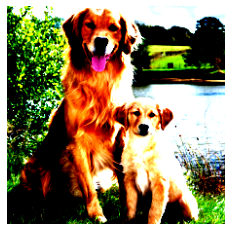

In [ ]:
plt.imshow(X.squeeze().transpose(0,-1).transpose(0,1))
plt.axis('off')
plt.show()

### Q 3.2 Perform an adversarial attack on the network. Make the model misclassify the example as a target class of your choice by performing gradient ascent in the input space. The resulting image should be imperceptibly different to the human eye from the original image.

In [ ]:
def make_fooling_image(X, target_y, model, lr=1000/1000):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image
    - target_y: An integer in the range [0, 1000)
    - model: Pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # TODO 
    model.eval()
    X_fooling = X.clone()
    X_fooling.requires_grad_()

    scores = model(X_fooling)
    y_hat = torch.max(scores, 1)[1].item()

    counter = 0
    while y_hat!=target_y:# and counter<100:
        counter += 1
        X_fooling.requires_grad_()
        scores = model(X_fooling)
        target_y_score = scores[0][target_y]
        if X_fooling.grad is not None:
            X_fooling.grad.zero_()
        target_y_score.backward()
        # if counter%20==0:
        #     print(counter, target_y_score)
        #     print(scores)
        #     print(y_hat)
        #     # print(X_fooling.grad.data)
        #     print()
        
        # print(X_fooling)
        # print(X_fooling.grad)
        with torch.no_grad():
            X_fooling = X_fooling + lr * X_fooling.grad.data
            scores = model(X_fooling)
            y_hat = torch.max(scores, 1)[1].item()

    return X_fooling

###### lr = 0.1

In [ ]:
model = models.resnet18(pretrained=True)
model.eval() # This is important. Can you guess why? Try commenting it out and see the result ;)
X = imagenet_transform(im).unsqueeze(0).to(device)
target_y = 620 # target label 620 in Imagenet corresponds to the "laptop" class

print(f"Predicted label using X :{idx2label[model(X).max(-1)[1].item()]}")
predicted_label_originally = idx2label[model(X).max(-1)[1].item()]

X_fooling = make_fooling_image(X, target_y=target_y, model=model, lr=0.1) 

predicted_label_after_fooling = idx2label[model(X_fooling).max(-1)[1].item()]
print(f"Predicted label using X_fooling :{predicted_label_after_fooling }")


Predicted label using X :golden_retriever
Predicted label using X_fooling :laptop


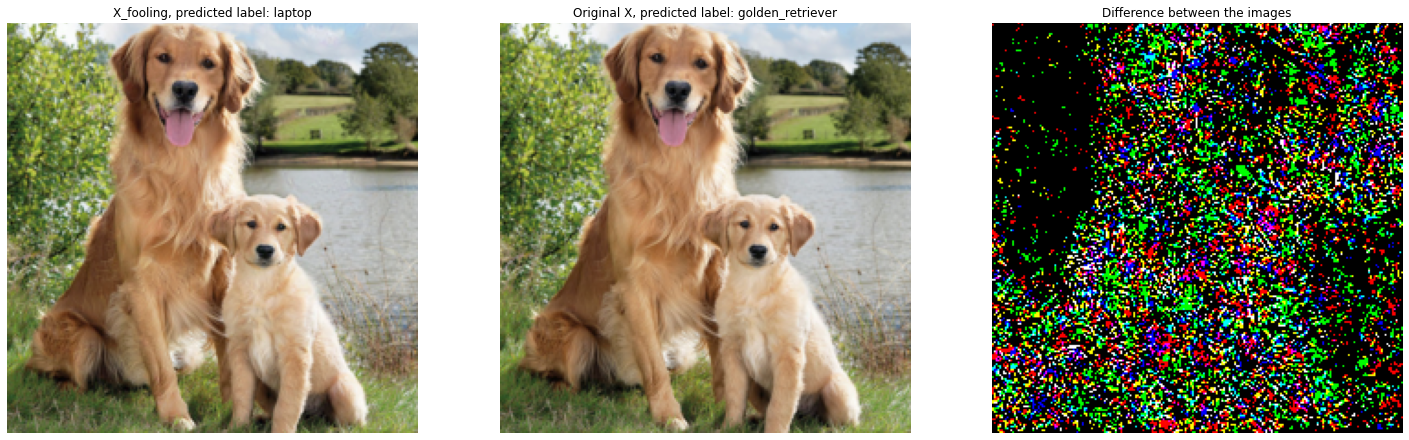

In [ ]:
# This cell output is what you should expect to see. 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(25)
f.set_figwidth(25)
ax1.imshow(make_viewable(X_fooling.squeeze()))
ax1.title.set_text(f'X_fooling, predicted label: {predicted_label_after_fooling}')
ax2.imshow(make_viewable(X.squeeze()))
ax2.title.set_text(f'Original X, predicted label: {predicted_label_originally}')
ax3.imshow(pil(inv_normalize(X_fooling.squeeze())- inv_normalize(X.squeeze())))
ax3.title.set_text(f'Difference between the images')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

###### lr = 1000/1000

In [ ]:
model = models.resnet18(pretrained=True)
model.eval() # This is important. Can you guess why? Try commenting it out and see the result ;)
X = imagenet_transform(im).unsqueeze(0).to(device)
target_y = 620 # target label 620 in Imagenet corresponds to the "laptop" class

print(f"Predicted label using X :{idx2label[model(X).max(-1)[1].item()]}")
predicted_label_originally = idx2label[model(X).max(-1)[1].item()]

X_fooling = make_fooling_image(X, target_y=target_y, model=model) 

predicted_label_after_fooling = idx2label[model(X_fooling).max(-1)[1].item()]
print(f"Predicted label using X_fooling :{predicted_label_after_fooling }")


Predicted label using X :golden_retriever
Predicted label using X_fooling :laptop


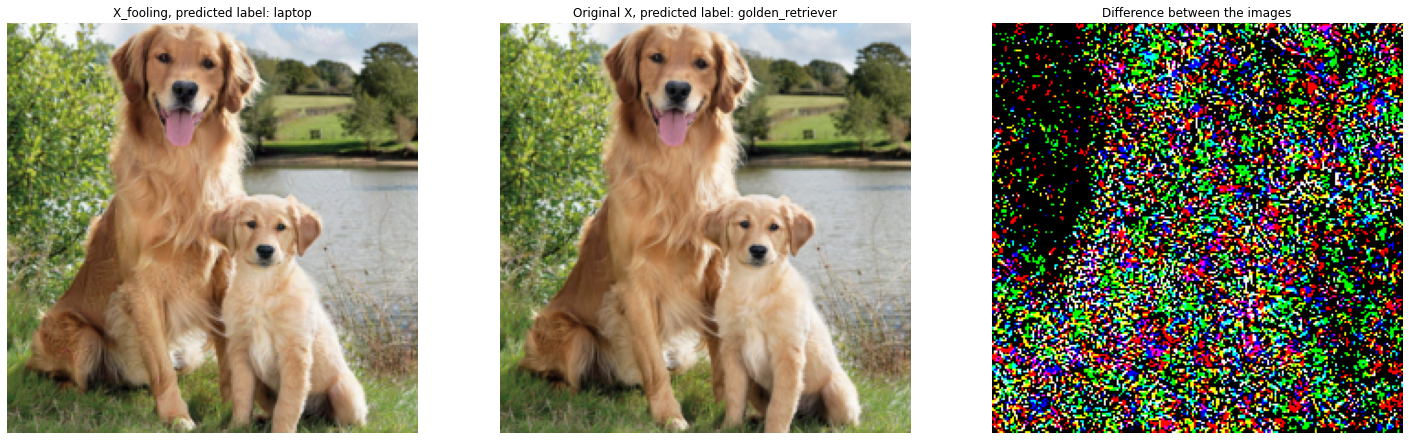

In [ ]:
# This cell output is what you should expect to see. 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(25)
f.set_figwidth(25)
ax1.imshow(make_viewable(X_fooling.squeeze()))
ax1.title.set_text(f'X_fooling, predicted label: {predicted_label_after_fooling}')
ax2.imshow(make_viewable(X.squeeze()))
ax2.title.set_text(f'Original X, predicted label: {predicted_label_originally}')
ax3.imshow(pil(inv_normalize(X_fooling.squeeze())- inv_normalize(X.squeeze())))
ax3.title.set_text(f'Difference between the images')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

###### lr = 1000 / 500

In [ ]:
model = models.resnet18(pretrained=True)
model.eval() # This is important. Can you guess why? Try commenting it out and see the result ;)
X = imagenet_transform(im).unsqueeze(0).to(device)
target_y = 620 # target label 620 in Imagenet corresponds to the "laptop" class

print(f"Predicted label using X :{idx2label[model(X).max(-1)[1].item()]}")
predicted_label_originally = idx2label[model(X).max(-1)[1].item()]

X_fooling = make_fooling_image(X, target_y=target_y, model=model) 

predicted_label_after_fooling = idx2label[model(X_fooling).max(-1)[1].item()]
print(f"Predicted label using X_fooling :{predicted_label_after_fooling }")


Predicted label using X :golden_retriever
Predicted label using X_fooling :laptop


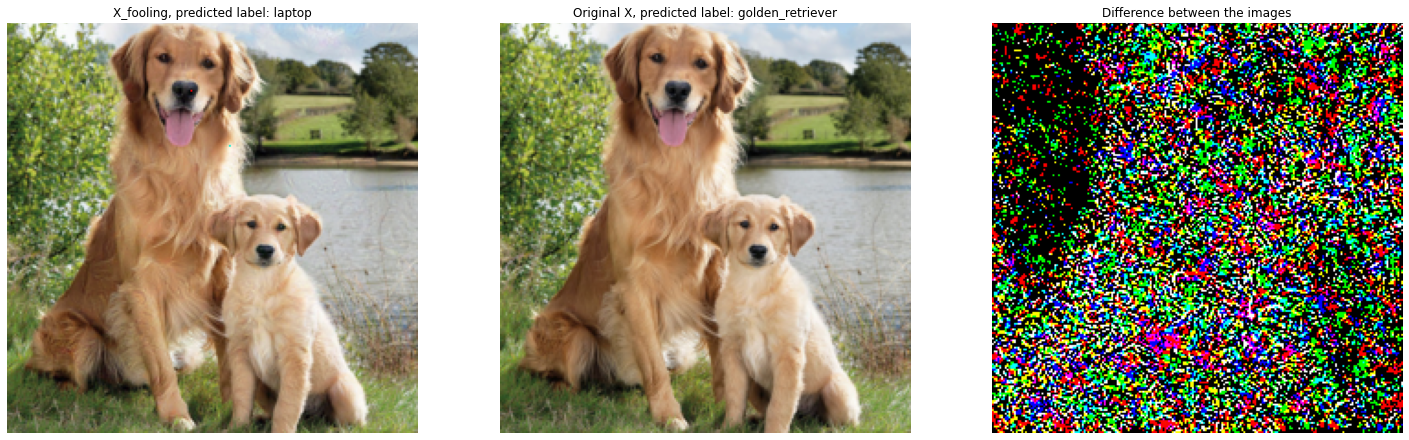

In [ ]:
# This cell output is what you should expect to see. 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(25)
f.set_figwidth(25)
ax1.imshow(make_viewable(X_fooling.squeeze()))
ax1.title.set_text(f'X_fooling, predicted label: {predicted_label_after_fooling}')
ax2.imshow(make_viewable(X.squeeze()))
ax2.title.set_text(f'Original X, predicted label: {predicted_label_originally}')
ax3.imshow(pil(inv_normalize(X_fooling.squeeze())- inv_normalize(X.squeeze())))
ax3.title.set_text(f'Difference between the images')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

###### Original

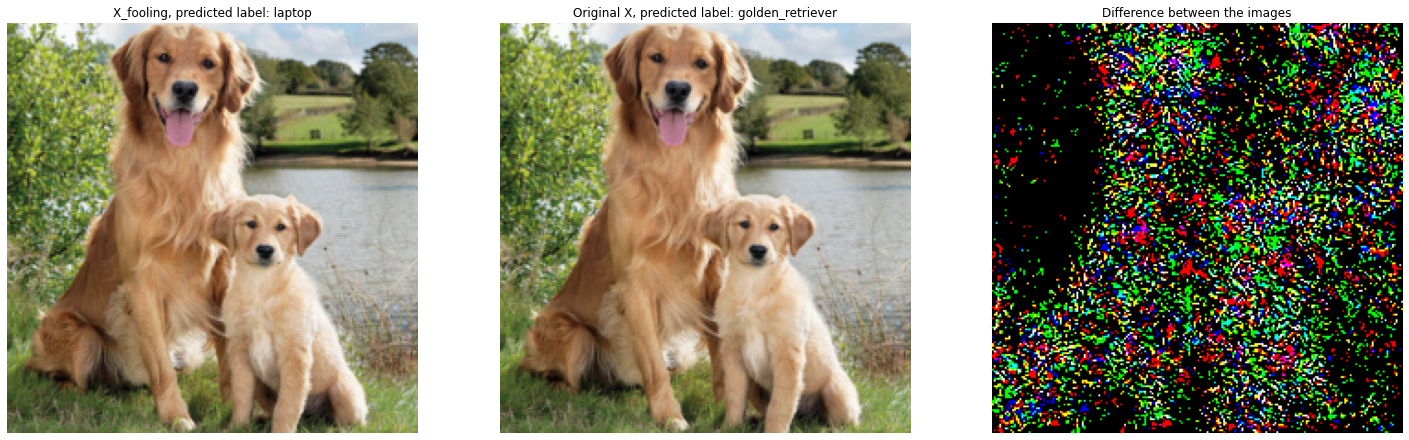

In [ ]:
# Original
# This cell output is what you should expect to see. 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(25)
f.set_figwidth(25)
ax1.imshow(to_pil(X_fooling.squeeze()))
ax1.title.set_text(f'X_fooling, predicted label: {predicted_label_after_fooling}')
ax2.imshow(to_pil(X.squeeze()))
ax2.title.set_text(f'Original X, predicted label: {predicted_label_originally}')
ax3.imshow(pil(inv_normalize(X_fooling.squeeze())- inv_normalize(X.squeeze())))
ax3.title.set_text(f'Difference between the images')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

### Q 3.3 Now download a different pre-trained model and see what class it predicts originally for the same model, and if our fooling image is also able to fool this other network. This is an instance of black box adversarial attack where without being able to directly optimize using a given model, you are still able to break it!

Hint: For example, try with VGG19. 

In [ ]:
def test_X_fooling(model, X, X_fooling):
    model.eval()
    target_y = 620 # target label 620 in Imagenet corresponds to the "laptop" class
    
    predicted_label_originally = idx2label[model(X).max(-1)[1].item()]
    print(f"Predicted label using X :{predicted_label_originally}")
    
    predicted_label_after_fooling = idx2label[model(X_fooling).max(-1)[1].item()]
    print(f"Predicted label using X_fooling :{predicted_label_after_fooling }")

###### lr = 1
I couldn't find any other models that is also fooled by the X_fooling image generated with ResNet18 when learning_rate = 1.

In [ ]:
test_X_fooling(model, X, X_fooling)

Predicted label using X :golden_retriever
Predicted label using X_fooling :laptop


In [ ]:
vgg19 = models.vgg19(pretrained=True)
test_X_fooling(vgg19, X, X_fooling)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


In [ ]:
vgg19_bn = models.vgg19_bn(pretrained=True)
test_X_fooling(vgg19_bn, X, X_fooling)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


In [ ]:
vgg16 = models.vgg16(pretrained=True)
test_X_fooling(vgg16, X, X_fooling)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


In [ ]:
vgg11 = models.vgg11(pretrained=True)
test_X_fooling(vgg11, X, X_fooling)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth



Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


###### lr = 0.1
I couldn't find any other models fooled by the X_fooling image either when learning_rate = 1.

In [ ]:
test_X_fooling(model, X, X_fooling)

Predicted label using X :golden_retriever
Predicted label using X_fooling :laptop


In [ ]:
vgg19 = models.vgg19(pretrained=True)
test_X_fooling(vgg19, X, X_fooling)

Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


In [ ]:
vgg19_bn = models.vgg19_bn(pretrained=True)
test_X_fooling(vgg19_bn, X, X_fooling)

Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


In [ ]:
vgg16 = models.vgg16(pretrained=True)
test_X_fooling(vgg16, X, X_fooling)

Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


In [ ]:
vgg11 = models.vgg11(pretrained=True)
test_X_fooling(vgg11, X, X_fooling)

Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


In [ ]:
googlenet = models.googlenet(pretrained=True)
test_X_fooling(googlenet, X, X_fooling)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth



Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


## Q 4 Localisation 

Here we will see how to use a model that was trained using images at a low resolution for localisation of objects in images at higher resolution. Plot the classifier response to the last feature map of the model before average pooling. 



HINT: You will need to use the "IntermediateLayerGetter" functionality to extract the last activations before the final avgpool layer and provide these to the final fully connected layer of the network to get the response. 


In [8]:
from torchvision.models._utils import IntermediateLayerGetter

# Refer to https://github.com/pytorch/vision/blob/master/torchvision/models/_utils.py

imagenet_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

In [9]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")
im = im.resize((int(im.size[0] *2.5), int(im.size[1] * 2.5)))
im

Output hidden; open in https://colab.research.google.com to view.

In [10]:
def localisation(X, model):
  """
  Generate a localisation map for the predicted class given an input 
  image and a pretrained CNN
  
  Inputs:
  - X: Input image
  - model: Pretrained CNN
  
  Returns:
  - localisation_map : An 2D heatmap of size 38 X 50
  """

  # TODO
  model.eval()
  
  predicted_class = torch.max(model(X), dim=1)[1].item()
  print(predicted_class, idx2label[predicted_class])

  last_layer = IntermediateLayerGetter(model, {'layer4':'last_layer'})
  feature_map = last_layer(X)['last_layer'] # Size([1, 2048, 38, 50])

  feature_map_reshaped = feature_map.squeeze().transpose(0,-1).transpose(0,1).view(-1, 2048) # Size([38*50, 2048])
  # feature_map_reshaped = feature_map.squeeze().view(2048,-1).transpose(0,1) # another way to reshape
  
  scores = model.fc(feature_map_reshaped) # Size([1900, 1000])
  scores = torch.nn.functional.softmax(scores, dim=1)

  target_class_scores = scores[:,predicted_class] # Size([1900, 1])
  localisation_map = target_class_scores.view(38, 50)

  return localisation_map

In [11]:
r50 = torchvision.models.resnet50(pretrained=True)
X = imagenet_transform(im).unsqueeze(0).to(device)
print(f"Size of input {X.shape}")
map = localisation(X, r50)

Size of input torch.Size([1, 3, 1200, 1600])
281 tabby


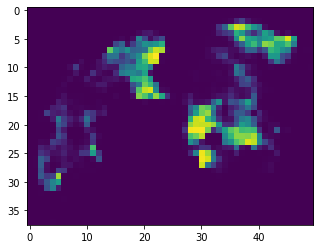

In [12]:
# Heatmap with an additional softmax after the final lienar layer
plt.imshow(map.cpu().detach())
plt.show()

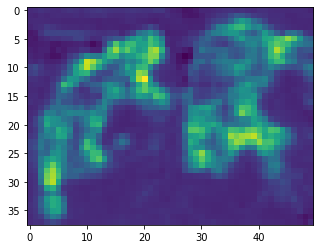

In [12]:
# This is the result I got without using softmax after the linear layer
plt.imshow(map.cpu().detach())
plt.show()

Original

In [ ]:
r50 = torchvision.models.resnet50(pretrained=True)
X = imagenet_transform(im).unsqueeze(0).to(device)
print(f"Size of input {X.shape}")
map = localisation(X, r50)

Size of input torch.Size([1, 3, 1200, 1600])
281 tabby


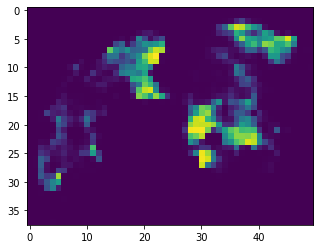

In [ ]:
plt.imshow(map.cpu().detach())
plt.show()